In [541]:
import json
from collections import Counter

class Deck:
    def __init__(self, info):
        self.name = info['deckName'][0]
        self.hero = info['hero'][0]
        self.cards = Counter()
        for name, [count] in info['cards'].items():
            self.cards[name] = count

training_path = 'data/trainingDecks.json'
test_path = 'data/testDecks.json'
            
def get_decks_dict(path):
    decks_dict = dict()    
    
    with open(path, 'r') as decks:
        for line in decks.readlines():
            json_info = json.loads(line)
            decks_dict[json_info['deckName'][0]] = Deck(json_info)
    return decks_dict

training_decks = get_decks_dict(training_path)
test_decks = get_decks_dict(test_path)

In [782]:
import pandas as pd
training_games = pd.read_csv('data/training_games.csv', delimiter=';', 
                             names=['id', 'bot1', 'deck1', 'bot2', 'deck2', 'result'])
print(training_games['result'].value_counts())

PLAYER_0 WON    165347
PLAYER_1 WON    134333
Name: result, dtype: int64


In [789]:
import pandas as pd
training_games = pd.read_csv('data/training_games.csv', delimiter=';', 
                             names=['id', 'bot1', 'deck1', 'bot2', 'deck2', 'result'])
training_games['result'] = training_games['result'] == 'PLAYER_1 WON'
training_games['result'] = training_games['result'].astype(int)
print(training_games.head())
print(len(training_games))

         id bot1       deck1 bot2       deck2  result
0  100001.0   A1  deck113225   A1  deck731599       0
1  100002.0   A1  deck694943   A1  deck929572       1
2  100003.0   A1  deck182567   A1  deck525929       0
3  100004.0   A1  deck219364   A1  deck757429       1
4  100005.0   A1  deck826229   A1  deck337123       1
299680


In [543]:
heros = {deck.hero for deck in training_decks.values()}
print(heros)

{'Warrior', 'Druid', 'Priest', 'Rogue', 'Paladin', 'Hunter', 'Mage', 'Warlock', 'Shaman'}


### Let's look at the cards

In [544]:
test_heros = {deck.hero for deck in test_decks.values()}
print(test_heros)

{'Warrior', 'Druid', 'Priest', 'Rogue', 'Hunter', 'Paladin', 'Mage', 'Warlock', 'Shaman'}


In [545]:
train_cards = set()
test_cards = set()
for deck in training_decks.values():
    train_cards.update(deck.cards.keys())

for deck in test_decks.values():
    test_cards.update(deck.cards.keys())

In [546]:
print(train_cards)
print(test_cards)

{'Dark Pact', 'Cornered Sentry', 'Innervate', 'Shadow Word: Death', 'Nourish', 'Mortal Coil', 'Divine Spirit', 'Glacial Shard', 'Vilespine Slayer', 'Booty Bay Bodyguard', 'Harrison Jones', 'Captured Jormungar', 'Mirror Entity', 'Holy Light', 'Bite', 'Jungle Panther', 'Divine Favor', 'Darkshire Councilman', 'King Mukla', 'Assassinate', 'Kirin Tor Mage', 'Arcane Blast', 'Murloc Tidecaller', 'Blessing of Kings', 'Malfurion the Pestilent', 'Silent Knight', 'Blowgill Sniper', 'Vulgar Homunculus', 'Rockpool Hunter', 'Explosive Runes', 'Volcanic Potion', 'Dragonfire Potion', 'Brawl', 'Puddlestomper', 'Grimscale Oracle', 'Coldlight Seer', 'Twilight Drake', 'Ultimate Infestation', 'Drain Soul', 'Abyssal Enforcer', 'Elven Archer', 'Azure Drake', 'Vilefin Inquisitor', 'Duskboar', 'Ironwood Golem', 'Patches the Pirate', 'Coldlight Oracle', 'Southsea Deckhand', 'Lost Tallstrider', 'Southsea Captain', 'Starfire', "Mogu'shan Warden", 'Houndmaster', 'Truesilver Champion', 'Raid Leader', 'Gnomish Inven

In [547]:
print(len(test_cards), len(train_cards))

313 330


In [548]:
all_cards = test_cards.intersection(train_cards)
print(len(all_cards))

295


In [626]:
train_df = training_games.get(['bot1', 'deck1', 'result']).rename(index=str, columns={'bot1': 'player', 'deck1': 'deck'})
train_df['result'] = 1 - train_df['result']
train_df = train_df.append([training_games.get(['bot2', 'deck2', 'result']).rename(index=str, columns={
    'bot2': 'player', 'deck2': 'deck'})])
train_df = train_df.groupby(['player', 'deck'])['result'].mean()
train_df = train_df.reset_index()
print(train_df.head())

  player        deck    result
0     A1  deck100087  0.291667
1     A1  deck101443  0.276627
2     A1  deck102280  0.550613
3     A1  deck104259  0.404459
4     A1  deck105300  0.397929


### Card names one hot encoding

In [738]:
def intersect_with_test_cards(cards_dict):
    keys = test_cards.intersection(cards_dict)
    return {k:cards_dict[k] for k in keys} 

In [739]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = [deck.cards for deck in training_decks.values()]
X = v.fit_transform(D)

In [740]:
heros_arr = np.zeros((len(train_df['deck']), len(test_heros)))

for i, deck_name in enumerate(train_df['deck']):
    for j, hero in enumerate(test_heros):
        heros_arr[i, j] = training_decks[deck_name].hero == hero

In [798]:
ai_rates_df = (training_games.groupby(['bot1'])['result'].mean() + 1 - training_games.groupby(['bot2'])['result'].mean()) / 2
ai_rates_dict = ai_rates_df.to_dict()
print(ai_rates_dict)

{'A1': 0.5479408387725019, 'A2': 0.4844957795425409, 'B1': 0.45799675245171284, 'B2': 0.442160634845661}


In [800]:
import numpy as np

players = ['A1', 'A2', 'B1', 'B2']

players_features = [(train_df['player'] == pl).as_matrix() for pl in players]
players_rates = np.array([ai_rates_dict[pl] for pl in train_df['player']])

x = np.array([v.transform(training_decks[deck_name].cards)[0] for deck_name in train_df['deck']])

In [803]:
print(players_rates.reshape(-1, 1).shape)

(1600, 1)


### Let's get some statistics for each card

In [742]:
card_stats = json.load(open('data/cards.json', 'r'))
json.dump(card_stats, open('data/formatted_cards.json', 'w'), indent=4)

In [743]:
card_stats = [stat for stat in card_stats if 'name' in stat]

In [744]:
stats_dict = {stat['name']:stat for stat in card_stats}

In [745]:
from collections import Counter

def aggregate_results(feature, fun, decks):
    counter = Counter()

    for stat in stats_dict.values():
        if feature in stat:
            counter[stat['name']] = stat[feature]
    
    def total_val(deck):
        total = 0
        cards = []
        for card, count in deck.cards.items():
            cards += [card] * count
        cards = [stats_dict[card].get(feature, 0) for card in cards]
        return fun(cards)

    return np.array([total_val(deck) for deck in decks])

In [836]:
card_features = ['cost', 'attack', 'health'#, 'durability', 'armor'
                ]
functions = [np.mean, np.median, np.var, 
             #np.max
            ]

tr_decks = [training_decks[deck_name] for deck_name in train_df['deck']]

def get_aggregated_features(decks=tr_decks):
    features_x = []
    for feature in card_features:
        for fun in functions:
            features_x.append(aggregate_results(feature, fun, decks))
    features_x = np.array(features_x)
    return features_x

features_x = get_aggregated_features()
print(features_x.shape)

(9, 1600)


In [837]:
players_x = np.stack(players_features).T
players_rates_x = players_rates.reshape(-1, 1)

In [838]:
print(features_x.T.shape)
print(heros_arr.shape)
print(players_x.shape)
print(players_rates_x.shape)
print(x.shape)

(1600, 9)
(1600, 9)
(1600, 4)
(1600, 1)
(1600, 330)


In [887]:

X = np.concatenate([x, 
                    players_x, 
                    players_rates_x,
                    features_x.T, 
                    heros_arr
                   ], axis=1)
y = train_df['result'].as_matrix()

In [888]:
print(X.shape)
print(y.shape)

(1600, 353)
(1600,)


**shufflujemy dataset**

In [889]:
import random
indices = random.sample(range(len(y)), len(y))
X = X[indices]
y = y[indices]
y *= 100

In [891]:
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

clf = SVR(gamma=0.001, epsilon=0.1, C=100, kernel='rbf')
gb = GradientBoostingRegressor()
gb_params = {'learning_rate': [0.3, 0.4, 0.5, 0.6, ],
            'max_depth': [3, 4],
             'n_estimators': [200, 300, 400, 500, 600]
            #'criterion': ['friedman_mse', 'mse'],
            #'max_features': [None, 'sqrt', 'log2']
            }

parameters = {'C': np.arange(1, 20) * 50, 
              'gamma': ['auto', 0.0005, 0.001, 0.005, 0.01, 0.02],
              'epsilon': [0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
             }

nn_params = {'hidden_layer_sizes': [(300,), (512,), (800,)]}

nn = MLPRegressor(hidden_layer_sizes=(512, ))

X_new = StandardScaler().fit_transform(X)

grid_clf = RandomizedSearchCV(gb, gb_params, scoring='neg_mean_squared_error', cv=8, verbose=5, n_jobs=7)
grid_clf = grid_clf.fit(X_new, y)
print(np.sqrt(-grid_clf.best_score_))
print(grid_clf.best_params_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-13.935758564449124, total=  16.1s
[CV] n_estimators=300, max_depth=4, learning_rate=0.3 ................
[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-13.730924632237505, total=  16.6s
[CV] n_estimators=500, max_depth=4, learning_rate=0.6 ................
[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-18.83723061284244, total=  18.7s
[CV] n_est

[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   19.0s


[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-15.96149970367693, total=  19.8s
[CV] n_estimators=500, max_depth=4, learning_rate=0.6 ................
[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-16.103731219769244, total=  20.4s
[CV] n_estimators=500, max_depth=4, learning_rate=0.6 ................
[CV]  n_estimators=300, max_depth=4, learning_rate=0.3, score=-18.596444233950415, total=  18.2s
[CV] n_estimators=500, max_depth=4, learning_rate=0.6 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.6, score=-17.293367084482014, total=  26.8s
[CV] n_estimators=500, max_depth=4, learning_rate=0.6 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.6, score=-19.322055435871633, total=  29.5s
[CV] n_estimators=400, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.6, score=-21.022780539956113, total=  32.3s
[CV] n_estimators=400, max_depth=3, learning_rate=0.4 ..........

[CV]  n_estimators=300, max_depth=3, learning_rate=0.5, score=-17.809597790837117, total=  13.9s
[CV] n_estimators=400, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=300, max_depth=3, learning_rate=0.5, score=-18.01198877634348, total=  13.0s
[CV] n_estimators=400, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-16.094144703897683, total=  18.4s
[CV] n_estimators=400, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-12.608713250837267, total=  18.0s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................


[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  2.9min


[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-15.775149749199654, total=  18.2s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-12.666267983580441, total=  17.9s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-16.480788253927795, total=  18.4s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-14.506783496353492, total=  19.3s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=400, max_depth=3, learning_rate=0.3, score=-15.464332048858605, total=  18.2s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ................
[CV]  n_estimators=300, max_depth=3, learning_rate=0.4, score=-16.76078441706881, total=  13.8s
[CV] n_estimators=300, max_depth=3, learning_rate=0.4 ..........

[Parallel(n_jobs=7)]: Done  80 out of  80 | elapsed:  3.5min finished


3.8945717857348083
{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.3}


In [872]:
import math

def reduce(x):
    x = np.array([max(val, 0) for val in x])
    return np.array([min(val, 100) for val in x])

In [892]:
svr_classifier = SVR(gamma=0.01, epsilon=0.02, C=100)
svr_classifier = svr_classifier.fit(X, y)
gb_classifier = GradientBoostingRegressor(n_estimators=500, learning_rate=0.3, max_depth=3, max_features=None)
gb_classifier = gb_classifier.fit(X, y)
#nn_classifier = MLPRegressor(hidden_layer_sizes=(512, ))
#nn_classifier = nn_classifier.fit(X, y)

In [897]:

def predict(deck, player, classifier, classifier2):
    players_features = [player == pl for pl in players]
    players_rates = [ai_rates_dict[player]]

    
    heros_arr = np.zeros((len(test_heros), ))

    for j, hero in enumerate(test_heros):
        heros_arr[j] = deck.hero == hero


    heros_arr = heros_arr.reshape(-1, 1)
    players_x = np.array(players_features).reshape(-1, 1)
    players_rates_x = np.array([players_rates]).reshape(-1, 1)
    features_x = get_aggregated_features([deck])
    x_test = np.array(v.transform([deck.cards]))
    x_test = x_test.reshape(-1, 1)
    X_pred = np.concatenate([x_test, 
                             players_x, 
                             players_rates_x,
                             features_x,
                             heros_arr])
    X_pred = X_pred.reshape(1, -1)
    preds = classifier.predict(X_pred) * 0.8 + classifier2.predict(X_pred) * 0.2
    return reduce(preds)


In [898]:

def get_test_decks_list():
    test_decks = []

    with open(test_path, 'r') as decks:
        for line in decks.readlines():
            json_info = json.loads(line)
            test_decks.append(json_info['deckName'][0])
    return test_decks

test_decks_names = get_test_decks_list()

def dump_results():
    df_results = pd.DataFrame()
    for player in players:
        for deck_name in test_decks_names:
            deck = test_decks[deck_name]
            win_rate = predict(deck, player, svr_classifier, gb_classifier)[0]
            df_results = df_results.append({'player': player, 'deck_name': deck_name, 'win_rate': win_rate}, 
                                           ignore_index=True)

    print(df_results.head())
    df_results.to_csv('data/test_results.csv', index=False, header=False, columns=['player', 'deck_name', 'win_rate'],
                     sep=';')
    return df_results

df_results = dump_results()

    deck_name player   win_rate
0  deck244804     A1  25.058818
1  deck124802     A1  43.822360
2  deck687350     A1  48.245318
3  deck517728     A1  47.278199
4  deck130762     A1  39.233798


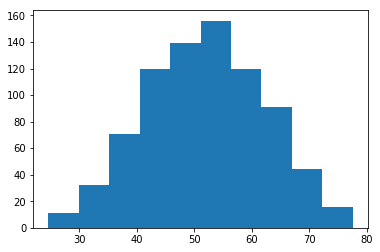

In [899]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_results['win_rate'])
plt.show()

In [900]:
print(np.mean(df_results['win_rate']))

51.90483198770591


In [903]:
heros = [deck.hero for deck in tr_decks]
tr_hero_counts = Counter(heros)
print(tr_hero_counts)

Counter({'Paladin': 268, 'Warlock': 264, 'Hunter': 264, 'Rogue': 144, 'Priest': 136, 'Mage': 136, 'Druid': 132, 'Shaman': 128, 'Warrior': 128})


In [905]:
test_heros = [deck.hero for deck in test_decks.values()]
test_hero_counts = Counter(test_heros)
print(test_hero_counts)

Counter({'Hunter': 33, 'Warlock': 33, 'Paladin': 32, 'Warrior': 19, 'Shaman': 18, 'Druid': 18, 'Priest': 17, 'Mage': 16, 'Rogue': 14})
